<a href="https://colab.research.google.com/github/PritamGoyal/isic2017/blob/main/dev_paper2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d awsaf49/isic-2017

100% 5.81G/5.82G [01:00<00:00, 105MB/s]
100% 5.82G/5.82G [01:00<00:00, 103MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/isic-2017.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv("/content/dataset/data.csv")
df

,image_id,image_path,mask_path,class,label
0,ISIC_0000000,/kaggle/input/isic-2017/images/images/ISIC_000...,/kaggle/input/isic-2017/masks/masks/ISIC_00000...,nev,2
1,ISIC_0000001,/kaggle/input/isic-2017/images/images/ISIC_000...,/kaggle/input/isic-2017/masks/masks/ISIC_00000...,nev,2
2,ISIC_0000002,/kaggle/input/isic-2017/images/images/ISIC_000...,/kaggle/input/isic-2017/masks/masks/ISIC_00000...,mel,0
3,ISIC_0000003,/kaggle/input/isic-2017/images/images/ISIC_000...,/kaggle/input/isic-2017/masks/masks/ISIC_00000...,nev,2
4,ISIC_0000004,/kaggle/input/isic-2017/images/images/ISIC_000...,/kaggle/input/isic-2017/masks/masks/ISIC_00000...,mel,0
...,...,...,...,...,...
1995,ISIC_0015220,/kaggle/input/isic-2017/images/images/ISIC_001...,/kaggle/input/isic-2017/masks/masks/ISIC_00152...,sk,1
1996,ISIC_0015233,/kaggle/input/isic-2017/images/images/ISIC_001...,/kaggle/input/isic-2017/masks/masks/ISIC_00152...,sk,1
1997,ISIC_0015260,/kaggle/input/isic-2017/images/images/ISIC_001...,/kaggle/input/isic-2017/masks/masks/ISIC_00152...,sk,1
1998,ISIC_0015284,/kaggle/input/isic-2017/images/images/ISIC_001...,/kaggle/input/isic-2017/masks/masks/ISIC_00152...,mel,0


In [ ]:
df['class'].value_counts()

nev    1372
mel     374
sk      254
Name: class, dtype: int64

In [ ]:
df['label'].value_counts()

2    1372
0     374
1     254
Name: label, dtype: int64

In [ ]:
rows_to_delete = df[df['label'] == 1].index
df.drop(rows_to_delete, inplace=True)

In [ ]:
rows_to_replace = df[df['class'] == 'nev'].index
df.loc[rows_to_replace, 'label'] = 1

In [ ]:
df['label'].value_counts()

1    1372
0     374
Name: label, dtype: int64

In [ ]:
df.drop(['image_path', 'mask_path','class'], axis=1, inplace=True)
df.head()

,image_id,label
0,ISIC_0000000,1
1,ISIC_0000001,1
2,ISIC_0000002,0
3,ISIC_0000003,1
4,ISIC_0000004,0


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from scipy.ndimage import median_filter
from skimage.transform import resize

In [ ]:

df['image_path'] = df['image_id'].apply(lambda x: f'/content/dataset/images/images/{x}.jpg')
df['preprocessed_path'] = df['image_id'].apply(lambda x: f'/content/preprocessed_images/{x}.jpg')


os.makedirs('/content/preprocessed_images', exist_ok=True)

In [ ]:

def preprocess_and_save_image(row):
    img = load_img(row['image_path'])
    img = img_to_array(img)
    img = resize(img, (224, 224), preserve_range=True, anti_aliasing=True)
    img = median_filter(img, size=3)  # Apply a median filter with size 3
    img = preprocess_input(img)  # Preprocess the image for ResNet50
    save_img(row['preprocessed_path'], img)

In [ ]:

df.apply(preprocess_and_save_image, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
1991    None
1992    None
1993    None
1994    None
1998    None
Length: 1746, dtype: object

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**IMAGES BEFORE AND AFTER PREPROCESSING**

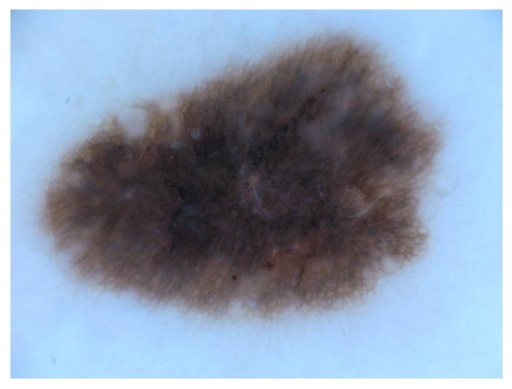

In [ ]:

img = mpimg.imread('/content/dataset/images/images/ISIC_0000000.jpg')


plt.imshow(img)
plt.axis('off')
plt.show()

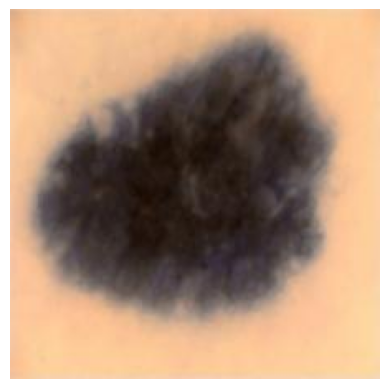

In [ ]:

img = mpimg.imread('/content/preprocessed_images/ISIC_0000000.jpg')


plt.imshow(img)
plt.axis('off')
plt.show()

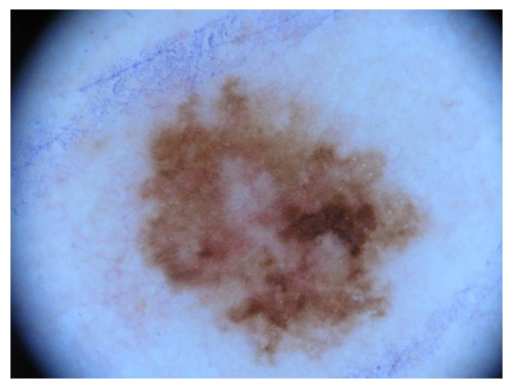

In [ ]:

img = mpimg.imread('/content/dataset/images/images/ISIC_0000002.jpg')


plt.imshow(img)
plt.axis('off')
plt.show()

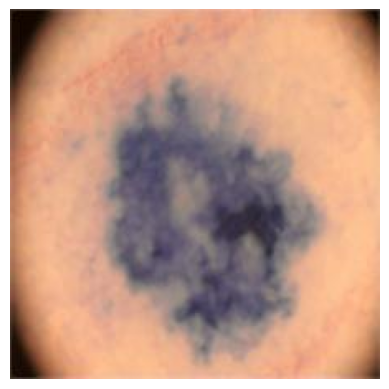

In [ ]:

img = mpimg.imread('/content/preprocessed_images/ISIC_0000002.jpg')


plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Convert label column values to strings
df['label'] = df['label'].astype(str)

In [ ]:
df['filename'] = df['image_id'].apply(lambda x: f'{x}.jpg')


image_dir = '/content/preprocessed_images'

# Initialize the data generator with preprocessing function
datagen = ImageDataGenerator(
    validation_split=0.2  # 80% training, 20% validation
)

In [ ]:
# Setup training and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 1397 validated image filenames belonging to 2 classes.
Found 349 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf

from tensorflow.keras.optimizers import Adam

# **ResNet50 base model**

In [ ]:
# Load ResNet50 base model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Assemble the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
import torch
import torchvision.models as models
from prettytable import PrettyTable

# Load a pretrained model (example: ResNet50)
model = models.resnet50(pretrained=True)

def count_parameters(model):
    table = PrettyTable(["Layer Name", "Output Shape", "Param #"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        layer_type = str(type(parameter).__name__)
        table.add_row([name, str(list(parameter.shape)), param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


+------------------------------+--------------------+---------+
|          Layer Name          |    Output Shape    | Param # |
+------------------------------+--------------------+---------+
|         conv1.weight         |   [64, 3, 7, 7]    |   9408  |
|          bn1.weight          |        [64]        |    64   |
|           bn1.bias           |        [64]        |    64   |
|    layer1.0.conv1.weight     |   [64, 64, 1, 1]   |   4096  |
|     layer1.0.bn1.weight      |        [64]        |    64   |
|      layer1.0.bn1.bias       |        [64]        |    64   |
|    layer1.0.conv2.weight     |   [64, 64, 3, 3]   |  36864  |
|     layer1.0.bn2.weight      |        [64]        |    64   |
|      layer1.0.bn2.bias       |        [64]        |    64   |
|    layer1.0.conv3.weight     |  [256, 64, 1, 1]   |  16384  |
|     layer1.0.bn3.weight      |       [256]        |   256   |
|      layer1.0.bn3.bias       |       [256]        |   256   |
| layer1.0.downsample.0.weight |  [256, 

25557032

In [ ]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
43/43 [==============================] - 6s 130ms/step - loss: 0.4934 - accuracy: 0.7949 - val_loss: 0.6106 - val_accuracy: 0.7563
Epoch 2/10
43/43 [==============================] - 6s 132ms/step - loss: 0.4808 - accuracy: 0.8007 - val_loss: 0.6257 - val_accuracy: 0.7500
Epoch 3/10
43/43 [==============================] - 5s 126ms/step - loss: 0.4724 - accuracy: 0.7978 - val_loss: 0.5787 - val_accuracy: 0.7625
Epoch 4/10
43/43 [==============================] - 5s 125ms/step - loss: 0.4626 - accuracy: 0.8029 - val_loss: 0.5918 - val_accuracy: 0.7500
Epoch 5/10
43/43 [==============================] - 5s 127ms/step - loss: 0.4586 - accuracy: 0.8022 - val_loss: 0.5869 - val_accuracy: 0.7531
Epoch 6/10
43/43 [==============================] - 6s 132ms/step - loss: 0.4510 - accuracy: 0.8081 - val_loss: 0.5710 - val_accuracy: 0.7563
Epoch 7/10
43/43 [==============================] - 6s 132ms/step - loss: 0.4418 - accuracy: 0.8066 - val_loss: 0.5839 - val_accuracy: 0.7594
Epoch 

In [ ]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

# Evaluate the model on the validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")


43/43 [==============================] - 5s 107ms/step - loss: 0.4242 - accuracy: 0.8110
Training Loss: 0.42420151829719543, Training Accuracy: 0.8110465407371521
10/10 [==============================] - 1s 102ms/step - loss: 0.5564 - accuracy: 0.7563
Validation Loss: 0.5564244985580444, Validation Accuracy: 0.7562500238418579


1/1 [==============================] - 0s 87ms/step


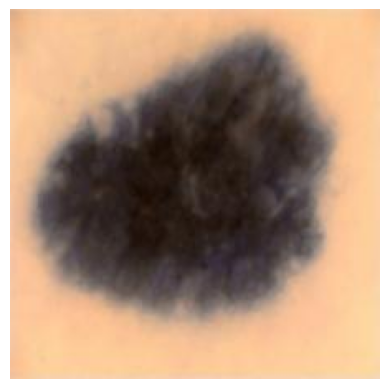

Model's Prediction: Class 1 (Probability: 0.9414691925048828)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model


image_path = '/content/preprocessed_images/ISIC_0000000.jpg'

# Load and preprocess the image
img = load_img(image_path, target_size=(224, 224))  # Resizing to match model's expected input
img_array = img_to_array(img)  # Convert the image to an array
img_array_expanded = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_preprocessed = preprocess_input(img_array_expanded)  # Preprocess the image

# Predict the class of the image
prediction = model.predict(img_preprocessed)

# Display the image
plt.imshow(img)
plt.axis('off')  # Don't show axes for images
plt.show()

# Print the prediction
predicted_class = 'Class 1' if prediction[0][0] > 0.5 else 'Class 0'
print(f"Model's Prediction: {predicted_class} (Probability: {prediction[0][0]})")


1/1 [==============================] - 0s 22ms/step


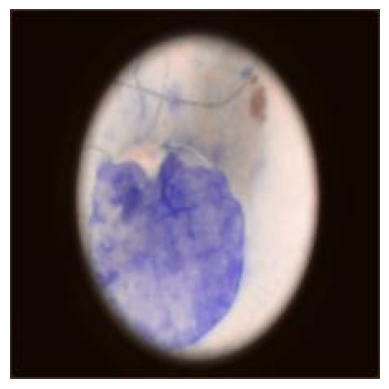

Model's Prediction: Class 1 (Probability: 0.9667564034461975)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model


image_path = '/content/preprocessed_images/ISIC_0000004.jpg'

# Load and preprocess the image
img = load_img(image_path, target_size=(224, 224))  # Resizing to match model's expected input
img_array = img_to_array(img)  # Convert the image to an array
img_array_expanded = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_preprocessed = preprocess_input(img_array_expanded)  # Preprocess the image

# Predict the class of the image
prediction = model.predict(img_preprocessed)

# Display the image
plt.imshow(img)
plt.axis('off')  # Don't show axes for images
plt.show()

# Print the prediction
predicted_class = 'Class 1' if prediction[0][0] > 0.5 else 'Class 0'
print(f"Model's Prediction: {predicted_class} (Probability: {prediction[0][0]})")


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


**All layers of the model**

In [ ]:
# Get the layers of the ResNet50 model
resnet_layers = model.layers[0].layers

# Print the layers
for layer in resnet_layers:
    print(layer.name)


input_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

**All layers with their weights**

In [ ]:
# Print the weights of all layers
for layer in model.layers:
    print("Layer Name:", layer.name)
    print("Weights:", layer.get_weights())
    print("----------------------------")


Streaming output truncated to the last 5000 lines.
       0.1572274 , 0.13403784, 0.14109257, 0.22213192, 0.20865603,
       0.2059391 , 0.30759248, 0.18720978, 0.17116277, 0.23522812,
       0.16938896, 0.18366632, 0.21061565, 0.08332255, 0.16085854,
       0.19446447, 0.16121292, 0.16100578, 0.31147182, 0.14421442,
       0.20049345, 0.1072548 , 0.19451916, 0.17334628, 0.14325252,
       0.21022215], dtype=float32), array([[[[-0.01023389, -0.01261035,  0.00080204, ...,  0.01435704,
           0.01899261,  0.00475871],
         [-0.00330907, -0.00051543, -0.00581124, ..., -0.0037636 ,
          -0.02398397, -0.01000349],
         [ 0.01481561, -0.00996176,  0.00611555, ..., -0.01134005,
           0.0089354 , -0.0179482 ],
         ...,
         [ 0.00206538, -0.00977799, -0.01281168, ..., -0.01303876,
          -0.01592073, -0.02198169],
         [ 0.01510699, -0.01854535, -0.00981662, ..., -0.01603035,
          -0.01194498,  0.00969215],
         [-0.02495344,  0.00140649,  0.00289

# **InceptionV3 base model**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the InceptionV3 base model, pretrained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Assemble the model for binary classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
import torch
import torchvision.models as models
from prettytable import PrettyTable

# Load a pretrained InceptionV3 model
model = models.inception_v3(pretrained=True)

def count_parameters(model):
    table = PrettyTable(["Layer Name", "Output Shape", "Param #"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        layer_type = str(type(parameter).__name__)
        table.add_row([name, str(list(parameter.shape)), param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 85.7MB/s]


+--------------------------------------+-------------------+---------+
|              Layer Name              |    Output Shape   | Param # |
+--------------------------------------+-------------------+---------+
|      Conv2d_1a_3x3.conv.weight       |   [32, 3, 3, 3]   |   864   |
|       Conv2d_1a_3x3.bn.weight        |        [32]       |    32   |
|        Conv2d_1a_3x3.bn.bias         |        [32]       |    32   |
|      Conv2d_2a_3x3.conv.weight       |   [32, 32, 3, 3]  |   9216  |
|       Conv2d_2a_3x3.bn.weight        |        [32]       |    32   |
|        Conv2d_2a_3x3.bn.bias         |        [32]       |    32   |
|      Conv2d_2b_3x3.conv.weight       |   [64, 32, 3, 3]  |  18432  |
|       Conv2d_2b_3x3.bn.weight        |        [64]       |    64   |
|        Conv2d_2b_3x3.bn.bias         |        [64]       |    64   |
|      Conv2d_3b_1x1.conv.weight       |   [80, 64, 1, 1]  |   5120  |
|       Conv2d_3b_1x1.bn.weight        |        [80]       |    80   |
|     

27161264

In [ ]:

# Initialize the data generator with preprocessing function suitable for InceptionV3
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use InceptionV3's preprocessing
    validation_split=0.2  # 80% training, 20% validation
)

# Setup training and validation generators, adjusting target_size to 299x299
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)




87910968/87910968 [==============================] - 1s 0us/step
Found 1397 validated image filenames belonging to 2 classes.
Found 349 validated image filenames belonging to 2 classes.
Epoch 1/10
43/43 [==============================] - 21s 289ms/step - loss: 0.5795 - accuracy: 0.7165 - val_loss: 0.5674 - val_accuracy: 0.7625
Epoch 2/10
43/43 [==============================] - 7s 151ms/step - loss: 0.5120 - accuracy: 0.7941 - val_loss: 0.5527 - val_accuracy: 0.7625
Epoch 3/10
43/43 [==============================] - 7s 158ms/step - loss: 0.5037 - accuracy: 0.7949 - val_loss: 0.5629 - val_accuracy: 0.7531
Epoch 4/10
43/43 [==============================] - 7s 161ms/step - loss: 0.4927 - accuracy: 0.7963 - val_loss: 0.5635 - val_accuracy: 0.7563
Epoch 5/10
43/43 [==============================] - 7s 152ms/step - loss: 0.4905 - accuracy: 0.7956 - val_loss: 0.5629 - val_accuracy: 0.7531
Epoch 6/10
43/43 [==============================] - 7s 159ms/step - loss: 0.4849 - accuracy: 0.7927 - v

In [ ]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

# Evaluate the model on the validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")


43/43 [==============================] - 7s 163ms/step - loss: 0.4582 - accuracy: 0.8001
Training Loss: 0.45822152495384216, Training Accuracy: 0.8001453280448914
10/10 [==============================] - 1s 128ms/step - loss: 0.5280 - accuracy: 0.7625
Validation Loss: 0.528018593788147, Validation Accuracy: 0.762499988079071


1/1 [==============================] - 3s 3s/step


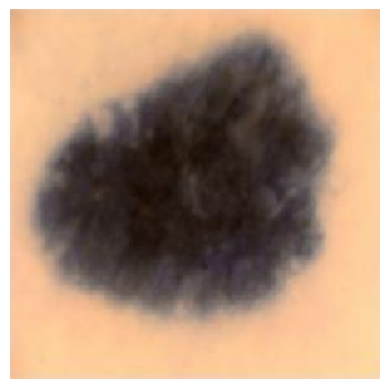

Model's Prediction: Class 1 (Probability: 0.8805913329124451)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import load_model

image_path = '/content/preprocessed_images/ISIC_0000000.jpg'

# Load and preprocess the image to match InceptionV3's expected input
img = load_img(image_path, target_size=(299, 299))
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_expanded)

# Predict the class of the image using InceptionV3
prediction = model.predict(img_preprocessed)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Print the prediction
predicted_class = 'Class 1' if prediction[0][0] > 0.5 else 'Class 0'
print(f"Model's Prediction: {predicted_class} (Probability: {prediction[0][0]})")


1/1 [==============================] - 0s 46ms/step


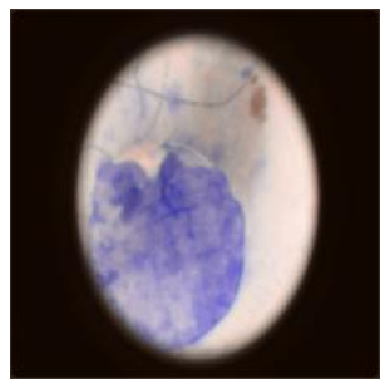

Model's Prediction: Class 1 (Probability: 0.7397938370704651)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import load_model


image_path = '/content/preprocessed_images/ISIC_0000004.jpg'

# Load and preprocess the image to match InceptionV3's expected input
img = load_img(image_path, target_size=(299, 299))
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_expanded)

# Predict the class of the image using InceptionV3
prediction = model.predict(img_preprocessed)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Print the prediction
predicted_class = 'Class 1' if prediction[0][0] > 0.5 else 'Class 0'
print(f"Model's Prediction: {predicted_class} (Probability: {prediction[0][0]})")


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


**ALL LAYERS OF THE MODEL**

In [ ]:
# Get the layers of the model
resnet_layers = model.layers[0].layers

# Print the layers
for layer in resnet_layers:
    print(layer.name)


input_4
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

**WEIGHTS OF ALL LAYERS**

In [ ]:
# Print the weights of all layers
for layer in model.layers:
    print("Layer Name:", layer.name)
    print("Weights:", layer.get_weights())
    print("----------------------------")


Streaming output truncated to the last 5000 lines.
         [-2.22562291e-02,  2.13535633e-02, -1.51940063e-02, ...,
          -1.42660933e-02,  1.32285408e-03,  1.37834921e-02],
         [-1.20829977e-03, -8.30138940e-03, -1.84125025e-02, ...,
          -1.88523885e-02, -1.00400178e-02, -9.67930723e-03],
         [-4.39228630e-03, -8.12219281e-04,  1.62090547e-02, ...,
           3.62504297e-03, -3.50786228e-04,  1.17053045e-02]],

        [[-6.56851567e-03,  1.20997224e-02,  3.58099677e-02, ...,
           4.83193854e-03, -2.31856592e-02, -3.84139121e-02],
         [-1.39521575e-02,  2.03453358e-02, -2.28565019e-02, ...,
          -2.55423272e-03, -3.34980362e-03, -7.89445639e-03],
         [-5.53381909e-03, -2.82207523e-02, -5.76807298e-02, ...,
           4.55435505e-03, -1.04289018e-02,  1.26639800e-02],
         ...,
         [-2.95909401e-03,  4.19526501e-03,  1.88410264e-02, ...,
           5.34881197e-04, -5.24851121e-03, -2.52288003e-02],
         [-2.37783592e-04, -4.3337256

# **VGG16 Base Model**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the VGG16 base model, pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Assemble the model for binary classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Initialize the data generator with preprocessing function suitable for VGG16
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Setup training and validation generators, adjusting target_size to 224x224 for VGG16
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


58889256/58889256 [==============================] - 1s 0us/step
Found 1397 validated image filenames belonging to 2 classes.
Found 349 validated image filenames belonging to 2 classes.
Epoch 1/10
43/43 [==============================] - 17s 250ms/step - loss: 1.0174 - accuracy: 0.5692 - val_loss: 1.2038 - val_accuracy: 0.6875
Epoch 2/10
43/43 [==============================] - 6s 146ms/step - loss: 0.8154 - accuracy: 0.6894 - val_loss: 1.2841 - val_accuracy: 0.7031
Epoch 3/10
43/43 [==============================] - 6s 149ms/step - loss: 0.7823 - accuracy: 0.7150 - val_loss: 1.2289 - val_accuracy: 0.7156
Epoch 4/10
43/43 [==============================] - 6s 145ms/step - loss: 0.7532 - accuracy: 0.7311 - val_loss: 1.2351 - val_accuracy: 0.7156
Epoch 5/10
43/43 [==============================] - 6s 147ms/step - loss: 0.7221 - accuracy: 0.7363 - val_loss: 1.0613 - val_accuracy: 0.7219
Epoch 6/10
43/43 [==============================] - 6s 148ms/step - loss: 0.7064 - accuracy: 0.7370 - v

In [ ]:
import torch
import torchvision.models as models
from prettytable import PrettyTable

# Load a pretrained model (example: VGG16)
model = models.vgg16(pretrained=True)

def count_parameters(model):
    table = PrettyTable(["Layer Name", "Output Shape", "Param #"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        layer_type = str(type(parameter).__name__)
        table.add_row([name, str(list(parameter.shape)), param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.6MB/s]


+---------------------+------------------+-----------+
|      Layer Name     |   Output Shape   |  Param #  |
+---------------------+------------------+-----------+
|  features.0.weight  |  [64, 3, 3, 3]   |    1728   |
|   features.0.bias   |       [64]       |     64    |
|  features.2.weight  |  [64, 64, 3, 3]  |   36864   |
|   features.2.bias   |       [64]       |     64    |
|  features.5.weight  | [128, 64, 3, 3]  |   73728   |
|   features.5.bias   |      [128]       |    128    |
|  features.7.weight  | [128, 128, 3, 3] |   147456  |
|   features.7.bias   |      [128]       |    128    |
|  features.10.weight | [256, 128, 3, 3] |   294912  |
|   features.10.bias  |      [256]       |    256    |
|  features.12.weight | [256, 256, 3, 3] |   589824  |
|   features.12.bias  |      [256]       |    256    |
|  features.14.weight | [256, 256, 3, 3] |   589824  |
|   features.14.bias  |      [256]       |    256    |
|  features.17.weight | [512, 256, 3, 3] |  1179648  |
|   featur

138357544

In [ ]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

# Evaluate the model on the validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")


43/43 [==============================] - 6s 137ms/step - loss: 0.6268 - accuracy: 0.7515
Training Loss: 0.6268324851989746, Training Accuracy: 0.7514534592628479
10/10 [==============================] - 1s 115ms/step - loss: 1.0435 - accuracy: 0.7125
Validation Loss: 1.0434587001800537, Validation Accuracy: 0.7124999761581421


1/1 [==============================] - 2s 2s/step


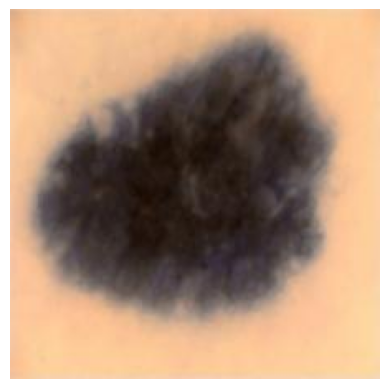

Model's Prediction: Class 1 (Probability: 0.9698706269264221)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model


image_path = '/content/preprocessed_images/ISIC_0000000.jpg'

# Load and preprocess the image to match VGG16's expected input
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_expanded)

# Predict the class of the image using VGG16
prediction = model.predict(img_preprocessed)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Print the prediction
predicted_class = 'Class 1' if prediction[0][0] > 0.5 else 'Class 0'
print(f"Model's Prediction: {predicted_class} (Probability: {prediction[0][0]})")


1/1 [==============================] - 0s 48ms/step


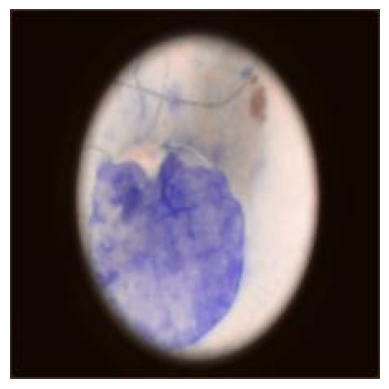

Model's Prediction: Class 1 (Probability: 0.9999685287475586)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model



image_path = '/content/preprocessed_images/ISIC_0000004.jpg'

# Load and preprocess the image to match VGG16's expected input
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_expanded)

# Predict the class of the image using VGG16
prediction = model.predict(img_preprocessed)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Print the prediction
predicted_class = 'Class 1' if prediction[0][0] > 0.5 else 'Class 0'
print(f"Model's Prediction: {predicted_class} (Probability: {prediction[0][0]})")


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


**ALL THE LAYERS OF THE MODEL**

In [ ]:
# Get the layers of the model
resnet_layers = model.layers[0].layers

# Print the layers
for layer in resnet_layers:
    print(layer.name)


input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


**WEIGHTS AS PER THE LAYERS**

In [ ]:
# Print the weights of all layers
for layer in model.layers:
    print("Layer Name:", layer.name)
    print("Weights:", layer.get_weights())
    print("----------------------------")


Layer Name: vgg16
Weights: [array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
      

## **WHY MEDIAN FILTER?**
Median filtering is a suitable preprocessing technique for the ISIC_2017 dataset due to its effectiveness in reducing noise while preserving edges and texture information in skin lesion images. It is robust to outliers, computationally efficient, and has fewer parameters to tune compared to other techniques. Its proven effectiveness and simplicity make it a popular choice for preprocessing tasks in medical image analysis.

## **Why VGG-16, ResNet50 and InceptionV3 as base models**
1. **VGG16**: VGG16 is a good choice for ISIC_2017 dataset classification due to its simplicity and effectiveness. It has relatively few layers compared to more modern architectures like ResNet50 and InceptionV3, making it less prone to overfitting, which can be beneficial for smaller datasets. Its architecture consists of repeated convolutional blocks followed by max-pooling layers, capturing hierarchical features that could be relevant for skin lesion classification.

2. **ResNet50**: ResNet50 is suitable for the ISIC_2017 dataset due to its deep architecture with residual connections, enabling the training of deeper networks without suffering from vanishing gradients. This architecture facilitates the extraction of intricate features from skin lesion images, potentially improving classification accuracy. ResNet50's deeper layers can capture both low-level and high-level features, which are crucial for discerning fine details in skin lesions.

3. **InceptionV3**: InceptionV3 is a good choice for ISIC_2017 dataset classification because of its inception modules, which incorporate multiple filter sizes within the same layer, allowing for efficient feature extraction at various scales. This architecture can capture both local and global features effectively, which is beneficial for classifying skin lesions with diverse textures, shapes, and sizes. Additionally, InceptionV3 has been trained on a large-scale dataset (ImageNet), enabling it to learn generic features that can be fine-tuned for skin lesion classification tasks.

In summary, VGG16, ResNet50, and InceptionV3 are good pretrained models for ISIC_2017 dataset classification due to their architectural characteristics, which enable effective feature extraction from skin lesion images, potentially leading to improved binary classification performance.